In [22]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
from tqdm.notebook import tqdm
from custom import weather

pd.options.mode.chained_assignment = None 
matplotlib.rcParams['font.family'] = ['PingFang HK']

def rmax(maxrow: int=50):
    pd.set_option('display.max_rows', maxrow)
def cmax(maxcol: int=50):
    pd.set_option('display.max_columns', maxcol)

# %load_ext autoreload
# %autoreload 2

## Load from saved station dataframe

In [23]:
df = pd.read_csv('all_station_20201126.csv')
## remove stations with data less than 1 year
df = df[df.data_duration>=12]

In [24]:
df[df.stn_name=='信義']

,stn_code,stn_name,altitude,Longitude,Latitude,city,address,data_start_date,stn_end_date,comment,orig_stn_code,new_stn_code,data_start_date2,data_duration,data_duration2,data_period
57,C0AC70,信義,71.0,121.564597,25.037822,臺北市,信義區市府路1號(台北市政府頂樓),2009/03/31,NaN,NaN,NaN,NaN,2015-01-01,70,5年10個月,2009/03/31-2020/11/26
181,C0I080,信義,536.0,120.851036,23.689694,南投縣,信義鄉自強村綠美巷(內茅埔營林區23林班地),2015/09/22,NaN,原(C1I080)站因擴充為氣象站，於2015/9/22升級為(C0I080)站。,C1I080,NaN,2015-09-22,62,5年2個月,2015/09/22-2020/11/26


## Load cleaned weather data

In [25]:
cmax(100)
df_w = pd.read_pickle('weather_all_cleaned.bz2')
# move index to columns for easier grouping
df_w.reset_index(inplace=True)
df_w['month'] = df_w.date.dt.month
df_w['year'] = df_w.date.dt.year
df_w.sample(5)

,stn_code,date,StnPres,StnPresMax,StnPresMin,Temperature,T Max,T Min,RH,RHMin,WS,WD,WSGust,WDGust,Precp,PresDif,TempDif,RHDif,month,year
785267,C0X260,2016-01-24,1026.2,1029.0,1021.5,5.6,8.9,4.6,72.0,57.0,7.1,27.0,18.0,34.0,4.0,7.5,4.3,15.0,1,2016
315111,C0G780,2020-08-01,1006.1,1007.9,1004.0,30.1,35.4,28.0,74.0,43.0,1.5,95.0,7.4,282.0,0.0,3.9,7.4,31.0,8,2020
521488,C0R440,2020-10-11,832.8,834.2,831.3,16.0,17.3,15.1,NaN,100.0,6.7,44.0,17.7,47.0,3.0,2.9,2.2,NaN,10,2020
250018,C0F850,2018-07-16,961.0,963.0,959.1,27.4,32.2,22.8,77.0,59.0,0.7,138.0,5.6,214.0,0.0,3.9,9.4,18.0,7,2018
678625,C0V400,2015-09-07,1001.2,1002.9,999.4,25.5,29.0,24.2,97.0,80.0,1.2,41.0,5.8,247.0,66.5,3.5,4.8,17.0,9,2015


In [26]:
col_WS = 'WS'

## Keep only stations with cleaned weather records data

In [27]:
# only keep weather stations without too many missing data (as filtered in the cleaned dataset)
df = df[df.stn_code.isin(df_w.stn_code.unique())]
df.shape

(446, 16)

## Make wind dir bins

In [28]:
#direction 0 means no wind, not direction, north is 360
df_w['WD'].replace({0: np.nan}, inplace=True)

In [29]:
bin_width = 10
nbin = 360//bin_width

# make Wind direction binning
bin_edge = np.linspace(bin_width//2, 360+bin_width//2, nbin+1)
bin_label = list(range(bin_width,360+bin_width,bin_width)) ## label is at the center of the bin (label:10 for edge[5,15])
print(bin_edge, bin_label)

## shift the 1-4 degree to 361-364 for better binning representation 
df_w['WD_shifted'] = df_w['WD']
df_w.loc[df_w.WD<bin_width//2, 'WD_shifted'] = df_w.WD+360
col_WD_bin = f'WD_bin_{bin_width}'
df_w[col_WD_bin] = pd.cut(df_w.WD_shifted, bins=bin_edge, labels=bin_label)

[  5.  15.  25.  35.  45.  55.  65.  75.  85.  95. 105. 115. 125. 135.
 145. 155. 165. 175. 185. 195. 205. 215. 225. 235. 245. 255. 265. 275.
 285. 295. 305. 315. 325. 335. 345. 355. 365.] [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250, 260, 270, 280, 290, 300, 310, 320, 330, 340, 350, 360]


In [30]:
# nbin = 36
# bin_start = (360/nbin)

# # make Wind direction binning
# bin10_edge = np.linspace(5, 365, 37)
# bin10_label = list(range(10,370,10)) ## label is at the center of the bin (label:10 for edge[5,15])
# print(bin10_edge, bin10_label)
# ## shift the 1-4 degree to 361-364 for better binning representation 
# df_w['WD_shifted'] = df_w['WD']
# df_w.loc[df_w.WD<5, 'WD_shifted'] = df_w.WD+360

# df_w['WD_bin10'] = pd.cut(df_w.WD_shifted, bins=bin10_edge, labels=bin10_label)

### test different cmap and levels

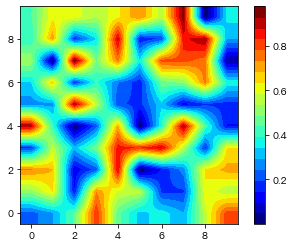

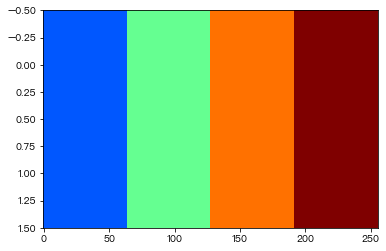

In [31]:
cmap = matplotlib.cm.get_cmap('jet', 20)
cmap4 = [cmap(i) for i in [4,9,15,19]]
chex = [matplotlib.colors.rgb2hex(i) for i in cmap4]

mat = np.random.random((10,10))
plt.imshow(mat, origin="lower", cmap=cmap, interpolation='bilinear')
plt.colorbar()
plt.show()

cmap_mod=matplotlib.colors.ListedColormap(cmap4)
gradient = np.linspace(0, 1, 256)
gradient = np.vstack((gradient, gradient))
plt.imshow(gradient, aspect='auto', cmap=cmap_mod)
plt.show()

In [32]:
type(chex)

list

## Function plot wind rose

In [33]:
def plot_wind_rose(df_temp, wd_bin_col, ws_col, ws_bin_edges=None, cmap='Blues', ax=None):
        
    ## make wind speed binning
    if ws_bin_edges is None:
        _, ws_bin_edges = pd.qcut(df_temp.WS, 4, retbins=True)
    df_temp['WS_bin'] = pd.cut(df_temp[ws_col], ws_bin_edges)
    df_temp['WS_bin_code'] = df_temp['WS_bin'].astype('category').cat.codes
    ws_labels = [f'{ws_bin_edges[i]}-{ws_bin_edges[i+1]} m/s' for i in range(len(ws_bin_edges)-1)]

    ## make colormaps
    if isinstance(cmap, str):
        cmap = matplotlib.cm.get_cmap(cmap, 10)
        cmap4 = [cmap(i) for i in [2,4,6,8]]
    else:
        cmap4 = cmap
    ## bar width
    nbin = len(df_temp[wd_bin_col].cat.categories)
    width = (2*np.pi) / nbin
    ## polar coord of the bar (center angles in radian)
    theta = np.linspace((2*np.pi)/nbin, 2*np.pi, nbin, endpoint=True)
#     print(np.degrees(theta))
    
    ## stacked polar bar plot
    if ax is None:
        ax = plt.subplot(111,polar=True)
    bottom=0
    for b in np.sort(df_temp.WS_bin_code.unique()):
        if b<0: ## for No wind situation WS=nan
            continue
        ws_bin = df_temp[df_temp.WS_bin_code==b]
        radii = ws_bin[wd_bin_col].value_counts(sort=False)
        bars = ax.bar(theta, radii, width=width, bottom=bottom, align='center',
            edgecolor = 'gray', linewidth=0, color=cmap4[b], label=ws_labels[b])
        bottom+=radii
        
    # set starting from 12o'clock and clockwise
    ax.set_theta_zero_location("N")
    ax.set_theta_direction(-1)
    # hide grid, spine and yticks
    ax.grid(alpha=0.3)
    ax.spines['polar'].set_visible(False)
    ax.set_yticks([])
#     ax.set_xticks([])
    # set the angle label
    xticks = ax.get_xticks()
    ax.set_xticks(xticks)
    # ax.set_xticks([0,np.pi/2,np.pi,np.pi*3/2])
#     ax.set_xticklabels(['N','', 'E','', 'S','', 'W',''])
    ax.set_xticklabels("")

    return ax

In [34]:
code_temp = 'C0W110'
m = 5

df_temp = df_w[df_w.stn_code==code_temp].reset_index(drop=True)
_, WS_bin_edges = pd.qcut(df_temp.WS, 4, retbins=True, duplicates='drop')

df_temp = df_temp[df_temp.month==m].reset_index(drop=True)

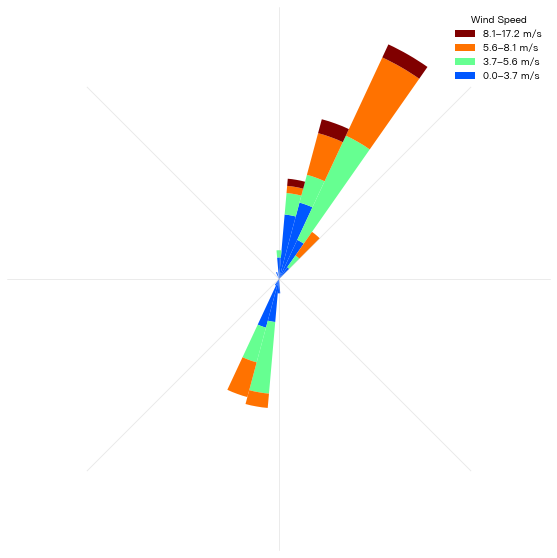

CPU times: user 5.1 s, sys: 87.7 ms, total: 5.18 s
Wall time: 5.17 s


In [35]:
%%time
fig, ax = plt.subplots(1, 1, figsize=(10,10), subplot_kw=dict(polar=True))
plot_wind_rose(df_temp, col_WD_bin, col_WS, ws_bin_edges=WS_bin_edges, cmap=chex, ax=ax)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], title='Wind Speed', loc='upper right', frameon=False)
plt.show()

### test plot g given station

In [25]:
### plot the average wind and wind gust

# for code in tqdm(codes_plot):

#     stn_name = df[df.iloc[:,0]==code].iloc[0,1]
#     print(f'plotting {stn_name}')
    
#     temp = df_w.loc[code]
#     temp['month'] = temp.index.month.astype('category')
#     temp['year'] = temp.index.year.astype('category')

#     fig, axes = plt.subplots(figsize=(12,15), ncols=3, nrows=4, subplot_kw=dict(polar=True))
# #     fig.suptitle(stn_name, fontsize=18, y=0.98)
#     bw=10
#     y_max=0
#     for m, ax in zip(np.r_[12,1:12], axes.flat):
#         temp_m = temp[temp.month==m]
#         wind = temp_m.WD
#         windG = temp_m.WDGust

#         ## Get the max wind gust speed and dir in full period (all years)
#         idx = temp_m.WSGust.idxmax()
#         G_max = temp_m.loc[idx, 'WSGust']
#         G_dir = temp_m.loc[idx, 'WDGust']
#     # #     counts, bins = np.histogram(temp_m.loc[idx.dropna()].WDGust, bins=(360//bw), range=[0,360])
#     #     ## 當月最大風速 "最常" 出現在那個方向. 
#     #     G_dir = bins[np.argmax(counts)]

#         radi_max = weather.plot_wind_gust(wind, windG, G_dir, G_max, bin_degree=10, ax=ax)
#         y_max = radi_max if (radi_max>y_max) else y_max
#         monthname = datetime.strptime(str(m), "%m").strftime("%B")
#         ax.set_title(monthname, x=0.1)
    
#     for ax in axes.flat:  ## set all subplot with the same maximum
#         ax.set_ylim(0,y_max)
        
#     plt.tight_layout()
#     plt.savefig(f'resources/{code}.png')
#     plt.close(fig)

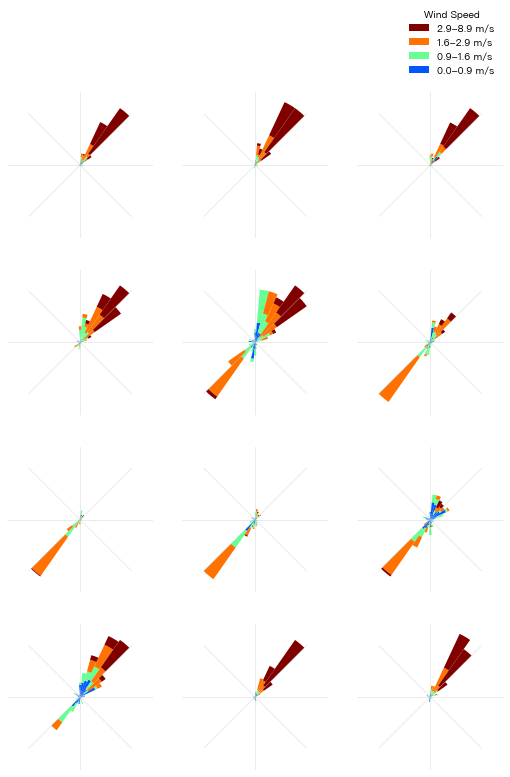

In [15]:
temp = df_w.loc[df_w.stn_code=='C0E540']
_, ws_bin_edges = pd.qcut(temp.WS, 4, retbins=True)
plt.rcParams['font.sans-serif'] = ['PingFang HK']
dpi = matplotlib.rcParams['figure.dpi']
fig_w = 640
fig_h = 900
ncol = 3
nrow = 4
fig, axes = plt.subplots(figsize=(fig_w/dpi,fig_h/dpi), ncols=ncol, nrows=nrow, subplot_kw=dict(polar=True))
# print(ws_bin_edges)
for m, ax in zip(np.r_[12,1:12], axes.flat):
    temp_m = temp[temp.month==m]
#     print(temp_m['WS'].unique())
#     temp_m['WS_bin'] = pd.cut(temp_m['WS'], ws_bin_edges)
#     print(temp_m['WS_bin'].unique())
#     temp_m['WS_bin_code'] = temp_m['WS_bin'].astype('category').cat.codes
#     ws_labels = [f'{ws_bin_edges[i]}-{ws_bin_edges[i+1]} m/s' for i in range(len(ws_bin_edges)-1)]
#     print(ws_labels)
    ax = plot_wind_rose(temp_m, col_WD_bin, col_WS, ws_bin_edges=ws_bin_edges, cmap=chex, ax=ax)
    handles, labels = ax.get_legend_handles_labels()
#     print(len(labels))
#     print(labels)
#     ax.cla()
handles, labels = axes[0][0].get_legend_handles_labels()
fig.legend(handles[::-1], labels[::-1], loc='upper right', bbox_to_anchor=(0.9, 0.98), 
           title='Wind Speed', frameon=False, ncol=1)


## plot and save wind directon plot for all stations

In [36]:
### plot the average wind with colorcoded ws(by WD)
icon=matplotlib.image.imread('resources/north_icon_s.png')

def create_windrose_allstn(df_stn, df_weather, col_wd, col_ws, save=False, cmap='Blues'):
    ''' 
    df_weather is the dataframe of full weather records, need to have 'month' column
    df, is the df of station information
    '''
    plt.rcParams['font.sans-serif'] = ['PingFang HK']
    dpi = matplotlib.rcParams['figure.dpi']
    fig_w = 640
    fig_h = 900
    ncol = 3
    nrow = 4
    
    for i, row in df_stn.iterrows():
#         print(f'plotting {row.stn_name}')
        temp = df_weather.loc[df_weather.stn_code==row.stn_code]
        ## get wind speed binning edges of this station
        _, ws_bin_edges = pd.qcut(temp.WS, 4, retbins=True, duplicates='drop')
                
        ## get the max value over 12 months for plot scaling 
        wdcount_max = temp.groupby(['month',col_wd]).date.count().max()
        
        ## set figure parameters
        fig, axes = plt.subplots(figsize=(fig_w/dpi,fig_h/dpi), ncols=ncol, nrows=nrow, subplot_kw=dict(polar=True))
        fig.subplots_adjust(bottom=0, top=0.85, left=0, right=1, wspace=0., hspace=0.)
        title = f'{row.stn_name}, {row.city}, Alt:{round(row.altitude)}m'
        fig.suptitle(title, fontsize=20, x=0.02, y=0.95, ha='left', va='top' )

        ## iterate through 12 months
        print(row.stn_name, ws_bin_edges)
        print(temp.WS.min(), temp.WS.max())
        for m, ax in zip(np.r_[12,1:12], axes.flat):
            temp_m = temp[temp.month==m]
            
            plot_wind_rose(temp_m, col_wd, col_ws, ws_bin_edges=ws_bin_edges, cmap=cmap, ax=ax)
            ## set normalize the max count to each station (whole year)
            ax.set_ylim(0,wdcount_max)
            ## print month on each rose plot
            monthname = datetime.strptime(str(m), "%m").strftime("%B")
            ax.set_title(monthname, x=0.1, y=0.95)
    
        ## add colorbar legend
        handles, labels = axes[0][0].get_legend_handles_labels()
        fig.legend(handles[::-1], labels[::-1], loc='upper right', bbox_to_anchor=(0.9, 0.98), 
                   title='Wind Speed', frameon=False, ncol=1)

        ## add north icon axe
        fig.figimage(icon, fig_w-230 , fig_h-90)
        if save:
            plt.savefig(f'resources/{row.stn_code}.png', facecolor='white', bbox_inches = 'tight', pad_inches = 0.1)
            plt.close(fig)

In [37]:
# create_windrose_allstn(df.sample(3), df_w, col_WD_bin, col_WS, save=False, cmap=chex)

## Plot with multiprocessing

In [38]:
## function to split the dataframe into n_process
def chunk_df(df, n):
    size=int(df.shape[0]/n)
    chunks=[]
    for i in range(n): 
        if i < (n-1):
            chunks.append(df[i*size:(i+1)*size])
        else:
            chunks.append(df[i*size:])
    return chunks

In [39]:
import multiprocessing as mp
from functools import partial

ncpu = mp.cpu_count()
# ncpu=8
chunks = chunk_df(df, ncpu)
## make a partial function with parameters other than the chunked dataframe
fn = partial(create_windrose_allstn, df_weather=df_w, col_wd=col_WD_bin, col_ws=col_WS, save=True, cmap=chex)

In [40]:
%%time
p = mp.Pool(processes = ncpu)
p.map(fn, chunks)

板橋 [0.3 1.2 1.8 2.6 8.4]
0.3 8.4
文山 [0.1 0.6 1.2 2.1 8.2]
0.1 8.2
頭份 [0.3 0.9 1.1 1.5 5.2]
0.3 5.2
二水 [0.  1.  1.2 1.4 5.2]
0.0 5.2
太保 [0.  1.  1.2 1.6 6.9]
0.0 6.9
舊泰武 [0.5 1.1 1.3 1.5 6. ]
0.5 6.0
雙連埤 [0.  0.3 0.5 0.7 4.8]
0.0 4.8
路竹 [1.  1.7 1.9 2.3 7.7]
1.0 7.7
造橋 [0.  0.7 1.  1.7 4.6]
0.0 4.6
淡水 新莊 [0.1 0.7 1.1 1.8 5.5]
0.1 5.5
[0.  1.2 1.5 2.  6.8]
0.0 6.8
伸港 [ 1.   2.   2.9  4.4 13.3]
1.0 13.3
水上 [ 0.5  1.4  1.8  2.3 10.5]
0.5 10.5
礁溪 [0.  0.5 0.8 1.  7.7]
0.0 7.7
墾雷 [0.7 2.1 3.1 4.5 9.5]
0.7 9.5
橋頭 [0.8 1.4 1.6 1.9 6.1]
0.8 6.1
苗栗 [0.5 1.2 1.6 2.6 6.1]
0.5 6.1
三芝 [0.6 1.3 1.6 1.9 6.5]
0.6 6.5
鞍部 [ 0.5  1.7  2.4  3.3 12.1]
0.5 12.1
線西 [1.3 2.4 3.2 4.3 8.8]
1.3 8.8
竹崎 [0.1 0.7 1.  1.4 6.2]
0.1 6.2
玉蘭 [ 0.   0.8  0.9  1.1 11.3]
0.0 11.3
東港 [1.3 2.  2.2 2.5 7.6]
1.3 7.6
大社 [0.6 1.  1.1 1.3 4.7]
0.6 4.7
臺北 [0.4 1.4 2.1 3.2 9.6]
0.4 9.6
埔里 [0.1 0.6 0.8 1.  2.9]
0.1 2.9
銅鑼 [0.1 0.5 0.7 1.  3.4]
0.1 3.4
八里 [0.4 1.4 1.8 2.3 6.1]
0.4 6.1
竹田 [0.7 1.1 1.3 1.5 4. ]
0.7 4.0
東石 [ 0.4  1.8  2.

## Plot map with wind stat image popup

In [60]:
from matplotlib import cm
import folium
import geocoder
import os
import base64


def map_with_windpopup(df, c_col, imagepath, cmap='Set1', location='Taiwan', zoom=9, jupyter=True):
    '''
    Create folium map with popup showing pre-generate images.
    Depending on whether the map need to be rendered in jupyter or in browser, 
    the way to embed image differs. In jupyter images need to be encoded in base64 
    string and save along the map html file. But for render in browser, the html
    link still works, and we don't need to embed images in html files but can be 
    loaded separately from img src="link".
    '''
    # create a color map
    ccode = df[c_col].astype('category').cat.codes
    cmap = cm.get_cmap(cmap, ccode.nunique())    # PiYG
    rgb = [matplotlib.colors.rgb2hex(cmap(i)[:3]) for i in range(cmap.N)]
    
    # create the location map
    g = geocoder.osm(location)
    latitude = g.latlng[0]
    longitude = g.latlng[1]
    
    # create the main map
    f = folium.Figure(width=1200, height=900)
    map_ = folium.Map(location=[latitude, longitude], zoom_start=zoom).add_to(f)    
    
    # add marker to map
    for c,(i,row) in zip(ccode, df.iterrows()):
        hovertext = f'{row.stn_name}, {row.city}, Alt {row.altitude}m'
        Filename =os.path.join(imagepath, f'{row.stn_code}.png')
        html = '<body style="background-color:#E9E9E9;">'
#         html += f"<b>{row.stn_name}{row.stn_code}, 資料期間:{row.data_duration2}</b>"
        if os.path.isfile(Filename):
            if jupyter:
            ## embed the image as base64 string inside the html file
                encoded = base64.b64encode(open(Filename, 'rb').read())
                html+=f'<img src="data:image/png;base64,{encoded.decode("UTF-8")}" style="width:100%;height:100%;">'
                html=folium.IFrame(html, width=700, height=600)
#                 popup=folium.Popup(iframe, max_width='100%', autoPan=True, keepInView=True)
            else:
            # load the image in resources folder
                html += f'<br><img src="{Filename}" width="800">'
        else:
#             print(f'file not exist:{Filename}')
            pass
        popup=folium.Popup(html, max_width='100%', keepInView=True)
        
        folium.CircleMarker(
            [row.Latitude, row.Longitude],
            radius=5,
            popup=popup,
            tooltip=hovertext,
            color=rgb[c],
            fill=True,
            fill_color=rgb[c],
            fill_opacity=0.9,
            parse_html=False).add_to(map_)
#         print(i, row.stn_name)
    
    return map_

In [ ]:
map_weather = map_with_windpopup(df2, c_col='city', imagepath='resources', 
                                 cmap='tab10', location='Taiwan', zoom=8, jupyter=False)
map_weather

## Save map as html
change the leaflet popup background color by inserting an extraline using beautifulsoup...

In [62]:
map_weather.save('index.html')

In [63]:
from bs4 import BeautifulSoup

soup = BeautifulSoup(open('index.html'), 'html.parser')
tag = soup.find_all('style')[-1]

tag.insert(0, ".leaflet-popup-content-wrapper {background-color: #E9E9E9}")

In [64]:
with open('index.html', "wb") as file:
    file.write(soup.prettify("utf-8"))